In [79]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

ĐỌC DỮ LIỆU

In [39]:
credits = pd.read_csv("C:\\Data Scientist\\credits.csv\\credits.csv")
keywords = pd.read_csv("C:\\Data Scientist\\keywords.csv\\keywords.csv")
movies = pd.read_csv("C:\\Data Scientist\\movies_metadata.csv\\movies_metadata.csv")

In [49]:
credits

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [48]:
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [47]:
movies

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [44]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [45]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [46]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

TIỀN XỬ LÝ DỮ LIỆU

In [51]:
#Ta xóa đi những trường dữ liệu không cần thiết
df_ = movies.drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1)

In [52]:
df_

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Rising and falling between a man and woman,4.0,1.0
45462,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",NaN,9.0,3.0
45463,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A deadly game of wits.,3.8,6.0
45464,False,0,[],227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],NaN,0.0,0.0


In [53]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45466 non-null  object 
 1   budget                45466 non-null  object 
 2   genres                45466 non-null  object 
 3   id                    45466 non-null  object 
 4   original_language     45455 non-null  object 
 5   original_title        45466 non-null  object 
 6   overview              44512 non-null  object 
 7   popularity            45461 non-null  object 
 8   production_companies  45463 non-null  object 
 9   production_countries  45463 non-null  object 
 10  release_date          45379 non-null  object 
 11  revenue               45460 non-null  float64
 12  runtime               45203 non-null  float64
 13  spoken_languages      45460 non-null  object 
 14  tagline               20412 non-null  object 
 15  vote_average       

In [54]:
for column in df_.columns:
    print(f"Cột {column} có các giá trị duy nhất sau: {df_[column].unique()}")

Cột adult có các giá trị duy nhất sau: ['False' 'True' ' - Written by Ørnås'
 ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.'
 ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.']
Cột budget có các giá trị duy nhất sau: ['30000000' '65000000' '0' ... '3417000' '25868826' '1254040']
Cột genres có các giá trị duy nhất sau: ["[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]" ...
 "[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name': 'Comedy'}, {'id': 28, 'name': 'Action'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 28, 'name': 'Action'}, {'id': 9648, 'name': 'Mystery'}, {'id': 53, 'name': 'Thriller'}, {'id': 27, 'name': 'Horror'}]"
 "[{'id

In [55]:
# Xử lý cột "adult"
valid_values = ['True', 'False']
df_ = df_[df_['adult'].isin(valid_values)]

# Chuyển đổi kiểu dữ liệu của cột "budget", 'id' và "popularity" sang số
df_['budget'] = pd.to_numeric(df_['budget'], errors='coerce')
df_['id'] = pd.to_numeric(df_['id'], errors='coerce')
df_['popularity'] = pd.to_numeric(df_['popularity'], errors='coerce')

# Chuyển đổi kiểu dữ liệu của cột "release_date" sang datetime
df_['release_date'] = pd.to_datetime(df_['release_date'], errors='coerce')

In [56]:
df_

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaT,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Rising and falling between a man and woman,4.0,1.0
45462,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",NaN,9.0,3.0
45463,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A deadly game of wits.,3.8,6.0
45464,False,0,[],227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],NaN,0.0,0.0


In [57]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45463 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45463 non-null  object        
 1   budget                45463 non-null  int64         
 2   genres                45463 non-null  object        
 3   id                    45463 non-null  int64         
 4   original_language     45452 non-null  object        
 5   original_title        45463 non-null  object        
 6   overview              44509 non-null  object        
 7   popularity            45460 non-null  float64       
 8   production_companies  45460 non-null  object        
 9   production_countries  45460 non-null  object        
 10  release_date          45376 non-null  datetime64[ns]
 11  revenue               45460 non-null  float64       
 12  runtime               45203 non-null  float64       
 13  spoken_languages     

In [58]:
df = df_.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

#Loại bỏ các hàng có ít nhất 1 giá trị thiếu
df.dropna(inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45558 entries, 0 to 46627
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45558 non-null  object        
 1   budget                45558 non-null  int64         
 2   genres                45558 non-null  object        
 3   id                    45558 non-null  int64         
 4   original_language     45558 non-null  object        
 5   original_title        45558 non-null  object        
 6   overview              45558 non-null  object        
 7   popularity            45558 non-null  float64       
 8   production_companies  45558 non-null  object        
 9   production_countries  45558 non-null  object        
 10  release_date          45558 non-null  datetime64[ns]
 11  revenue               45558 non-null  float64       
 12  runtime               45558 non-null  float64       
 13  spoken_languages     

In [60]:
df.head(1)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."


In [61]:
from ast import literal_eval

def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [62]:
df.head(1)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42373 non-null  object        
 1   budget                42373 non-null  int64         
 2   genres                42373 non-null  object        
 3   id                    42373 non-null  int64         
 4   original_language     42373 non-null  object        
 5   original_title        42373 non-null  object        
 6   overview              42373 non-null  object        
 7   popularity            42373 non-null  float64       
 8   production_companies  42373 non-null  object        
 9   production_countries  42373 non-null  object        
 10  release_date          42373 non-null  datetime64[ns]
 11  revenue               42373 non-null  float64       
 12  runtime               42373 non-null  float64       
 13  spoken_languages

TRỰC QUAN HÓA DỮ LIỆU

Các bộ phim có và không có nội dung cho người trưởng thành ("Adult" và "Non Adult")

In [64]:
print(df['adult'].unique())

['False' 'True']


In [65]:
df['adult'] = df['adult'].map({'False': False, 'True': True})

counts = df['adult'].value_counts()

print("Số lượng phim dành cho người trưởng thành (Adult):", counts[True])
print("Số lượng phim không dành cho người trưởng thành (Non Adult):", counts[False])

Số lượng phim dành cho người trưởng thành (Adult): 8
Số lượng phim không dành cho người trưởng thành (Non Adult): 42365


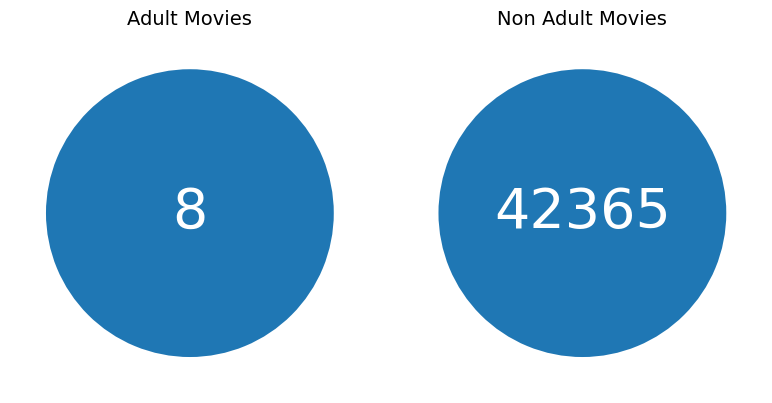

In [66]:
num_movies = [counts[True], counts[False]]
categories = ['Adult', 'Non Adult']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.pie([8], startangle=140)
plt.title('Adult Movies', fontsize=14)
plt.text(0, 0, '8', color='white', fontsize=40, va='center', ha='center')

plt.subplot(1, 2, 2)
plt.pie([42365], startangle=140)
plt.title('Non Adult Movies', fontsize=14)
plt.text(0, 0, '42365', color='white', fontsize=40, va='center', ha='center')

plt.tight_layout()
plt.show()

Sự ảnh hưởng của Ngân sách và Doanh thu so với Độ phổ biến

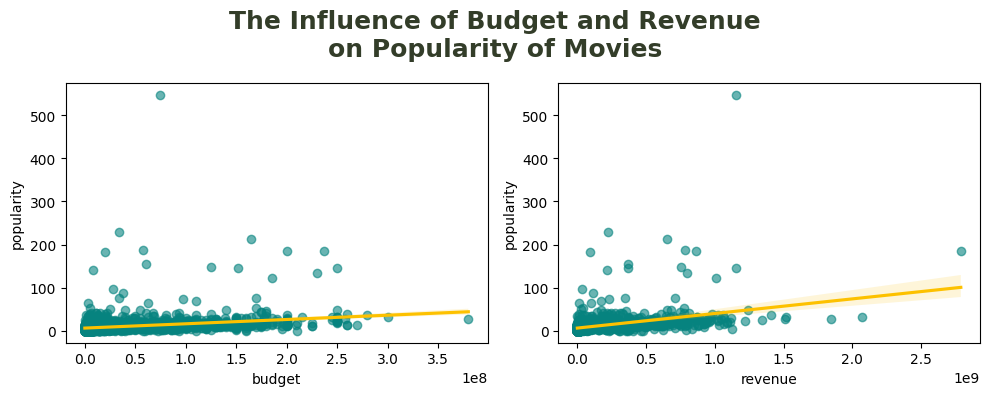

In [69]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

Sự thành công của bộ phim

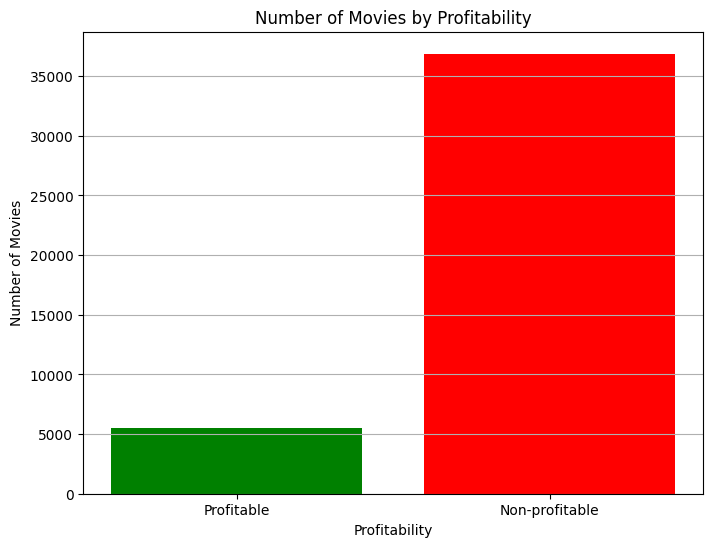

In [70]:
df['profit'] = df['revenue'] - df['budget']
profitable_count = df[df['profit'] > 0].shape[0]
non_profitable_count = df[df['profit'] <= 0].shape[0]

categories = ['Profitable', 'Non-profitable']
counts = [profitable_count, non_profitable_count]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['green', 'red'])
plt.xlabel('Profitability')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Profitability')
plt.grid(axis='y')
plt.show()

Các từ khóa phổ biến của phần tóm tắt phim

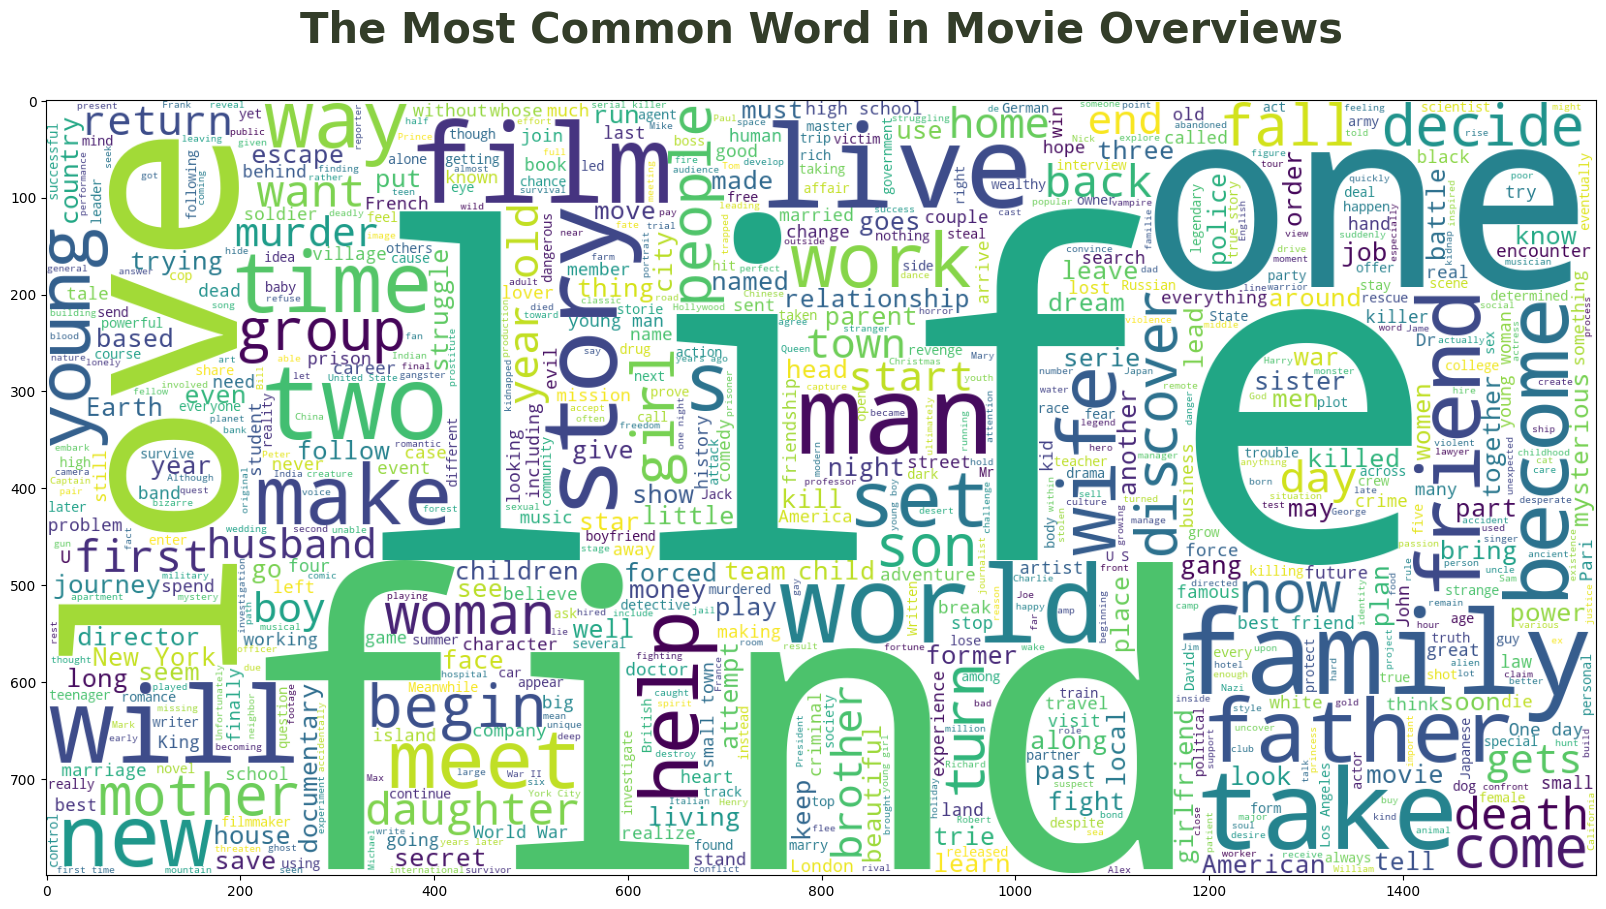

In [71]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

Sự phân bố Thể loại phim

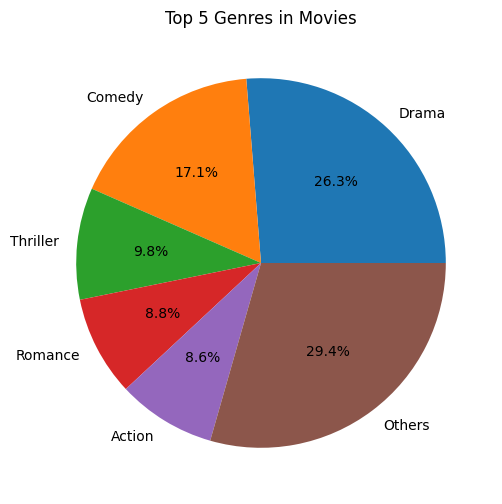

In [73]:
genres_list = []
for genres in df['genres']:
    genres_list.extend(genres.split(', '))

genre_counts = pd.Series(genres_list).value_counts()

top_genres = genre_counts.head(5)

percentage = (top_genres / top_genres.sum()) * 100

other_genre_count = genre_counts.sum() - top_genres.sum()
top_genres['Others'] = other_genre_count
percentage['Others'] = (other_genre_count / genre_counts.sum()) * 100

plt.figure(figsize=(6, 6))
plt.pie(percentage, labels=percentage.index, autopct='%.1f%%')
plt.title('Top 5 Genres in Movies')
plt.show()

Sự phát triển của ngành công nghiệp điện ảnh

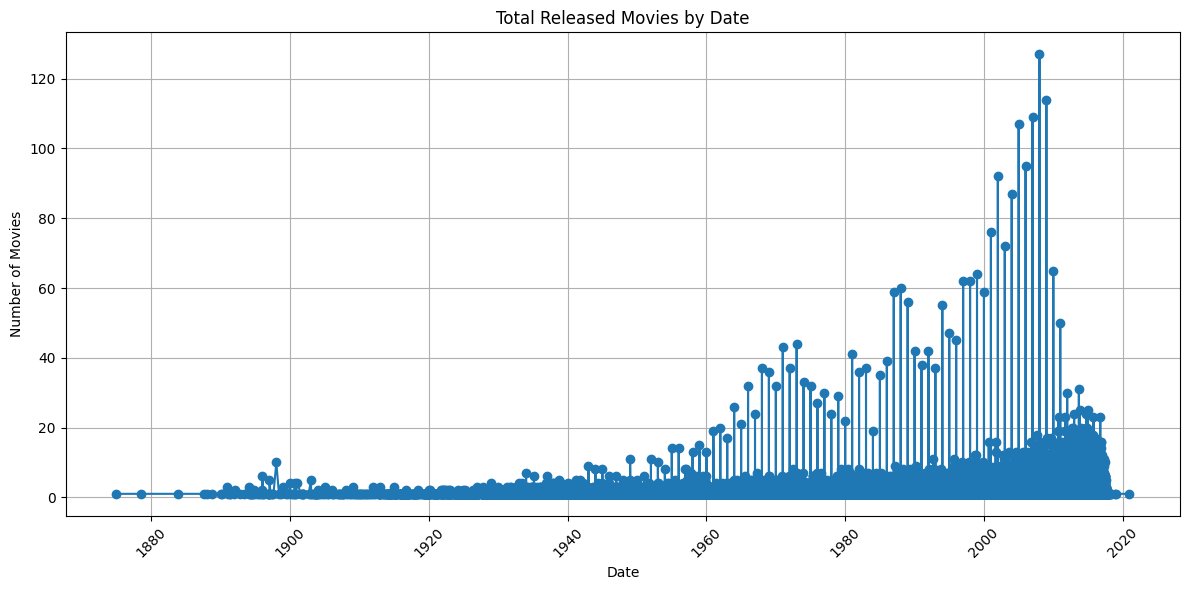

In [74]:
movie_count_by_date = df['release_date'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(movie_count_by_date.index, movie_count_by_date.values, marker='o', linestyle='-')
plt.title('Total Released Movies by Date')
plt.xlabel('Date')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Top 5 các hạng mục (Diễn viên, Ngôn ngữ, ...)

In [75]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

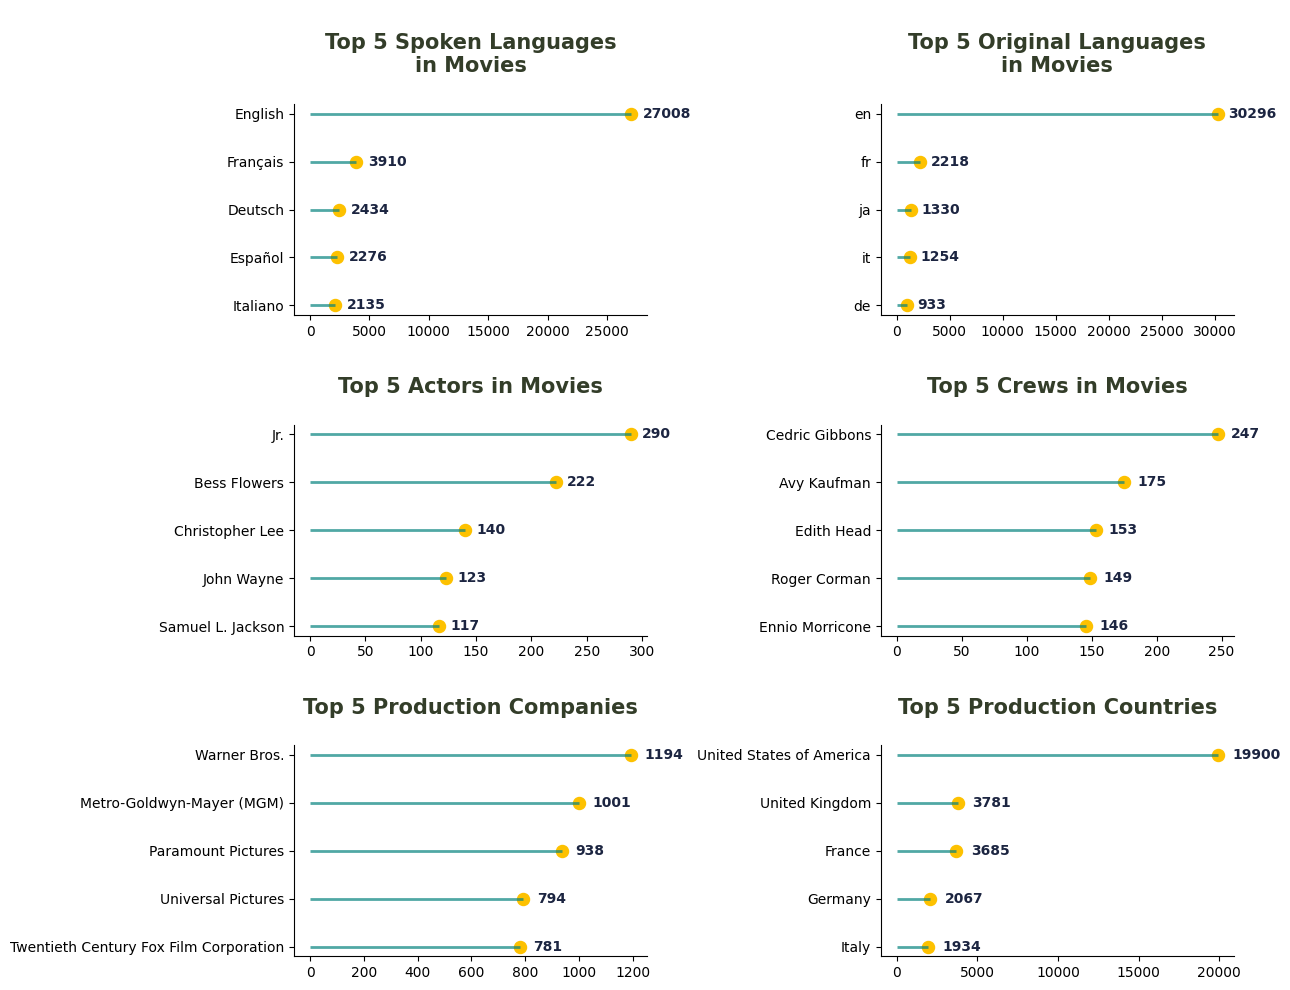

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

Mối quan hệ giữa xếp hạng (rating) và độ phổ biến của các bộ phim (popularity)

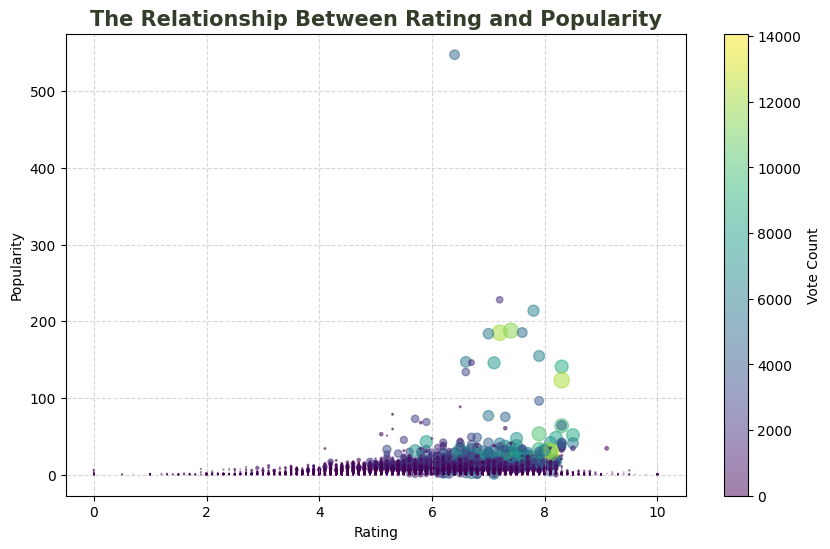

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(df['vote_average'], df['popularity'], s=df['vote_count']/100, c=df['vote_count'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Vote Count')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')
plt.xlabel('Rating')
plt.ylabel('Popularity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ma trận tương quan

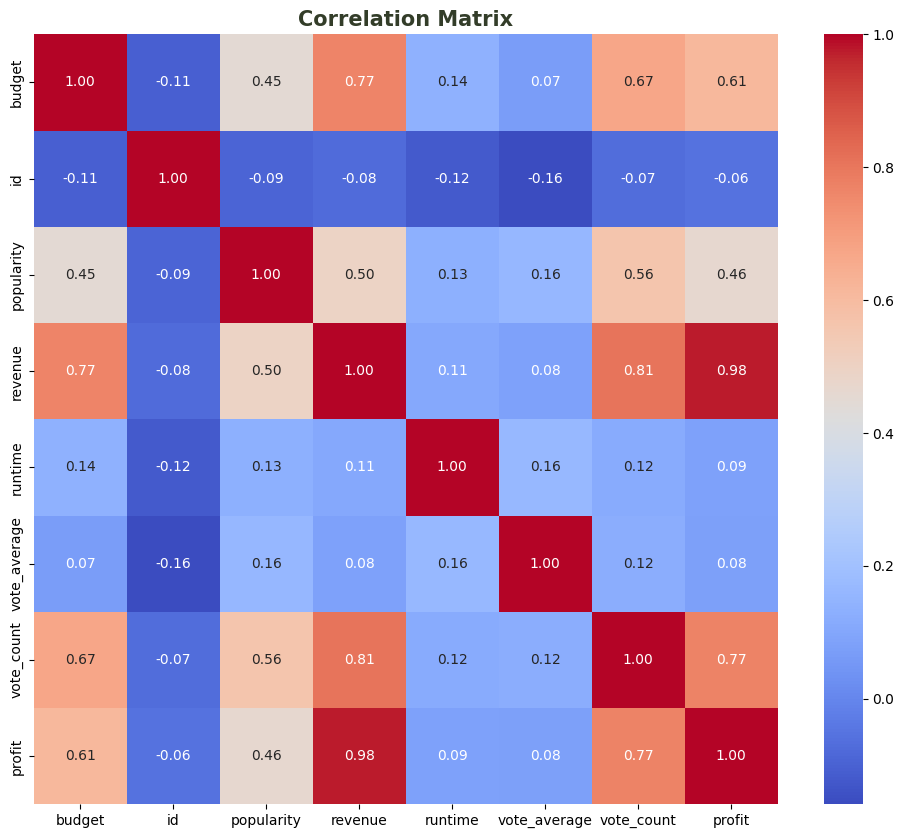

In [77]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=15, weight=600, color='#333d29')
plt.show()

Số lượng phim của các quốc gia

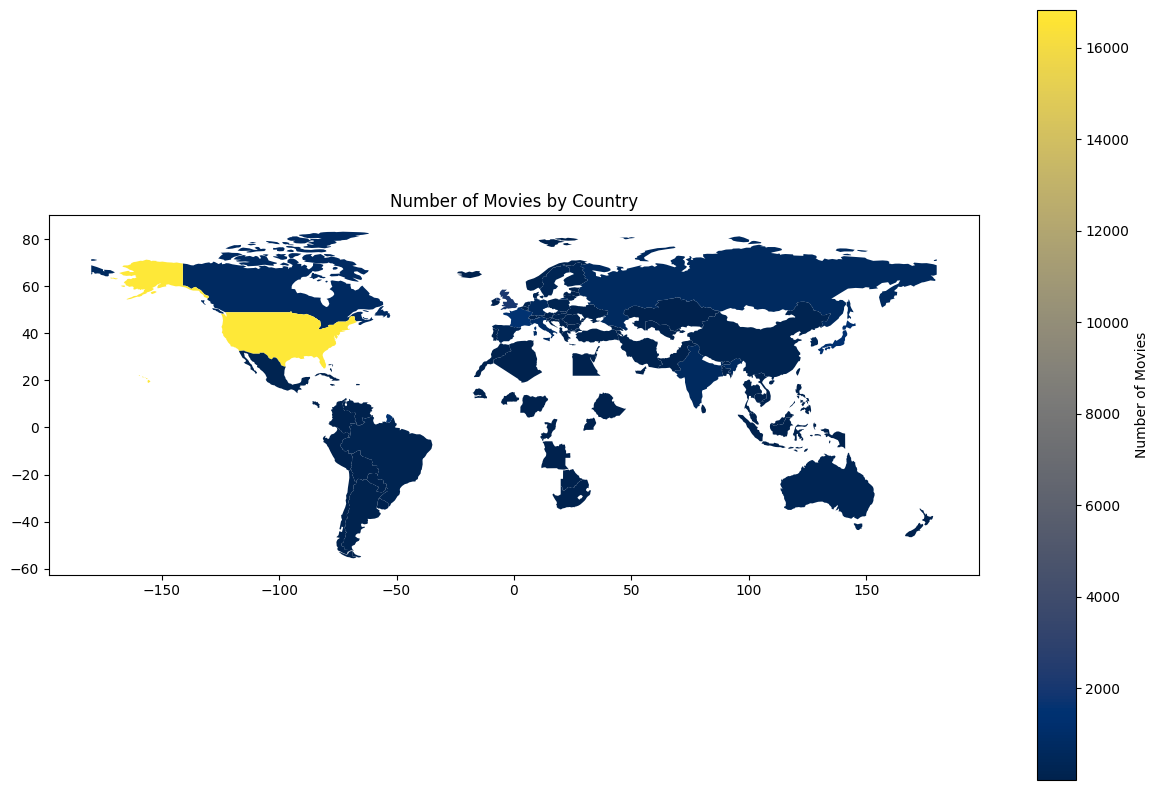

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
movies_by_country = df.groupby('production_countries').size().reset_index(name='num_movies')
world = world.merge(movies_by_country, how='left', left_on='name', right_on='production_countries')

world.plot(column='num_movies', cmap='cividis', figsize=(15, 10), legend=True, legend_kwds={'label': 'Number of Movies'})
plt.title('Number of Movies by Country')
plt.show()

CONTENT-BASED

In [81]:
R = df['vote_average']
v = df['vote_count']

m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [82]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [83]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [84]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [85]:
content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [86]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) 
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [88]:
content_df['adult'] = content_df['adult'].astype(str)
content_df['adult'] = content_df['adult'].apply(remove_punc)
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['characters'] = content_df['characters'].apply(separate)
content_df['actors'] = content_df['actors'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [89]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [90]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [91]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [92]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317
